In [338]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as opt
import scipy.signal as sig

In [371]:
base_path = "/Volumes/DATA/"
sphere_data = ["20230925/meas/1",
               "20230925/meas/2",
                "20230925/meas/3",
                "20230925/meas/4",
                "20230925/meas/5",
                "20230925/meas/6",
                "20230925/meas/7",
                "20230925/meas/8",
                "20230925/meas/9",
                "20230925/meas/10",
                "20230925/meas/11",
                "20230925/meas/12",]
file_label= '20230925'
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)
remake_files = False

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/data/20230925


In [340]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

Drive frequency is: 111.08 Hz


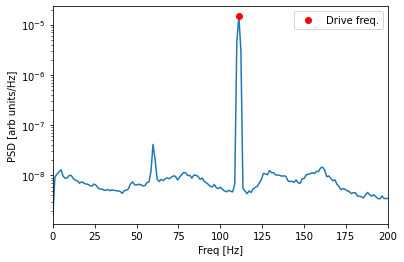

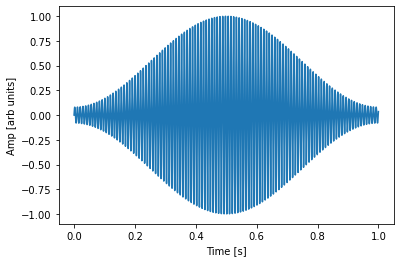

In [341]:
## make a template for the charge measurement
importlib.reload(bu)
dat, attr, _ = bu.get_data(data_list[0])
drive_template, drive_freq = bu.correlation_template_cw(dat, attr, length=1, make_plots=True)

In [342]:
importlib.reload(bu)

if(remake_files):
    charge_vec = []
    corr_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=2**16)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])

    charge_vec = np.array(charge_vec)
    np.save(data_dir+"/charge_steps_%s.npy"%file_label, charge_vec)
    np.save(data_dir+"/charge_steps_vec_%s.npy"%file_label, corr_vec)
else:
    charge_vec = np.load(data_dir+"/charge_steps_%s.npy"%file_label)
    corr_vec = np.load(data_dir+"/charge_steps_vec_%s.npy"%file_label)

In [343]:
## Make a list of folder numbers 

folder_vec = []
for f in data_list:
    parts = f.split('/')
    folder_vec.append([int(parts[5])]*16)
folder_vec = np.ndarray.flatten(np.array(folder_vec))
print(folder_vec)


[ 1  1  1 ... 12 12 12]


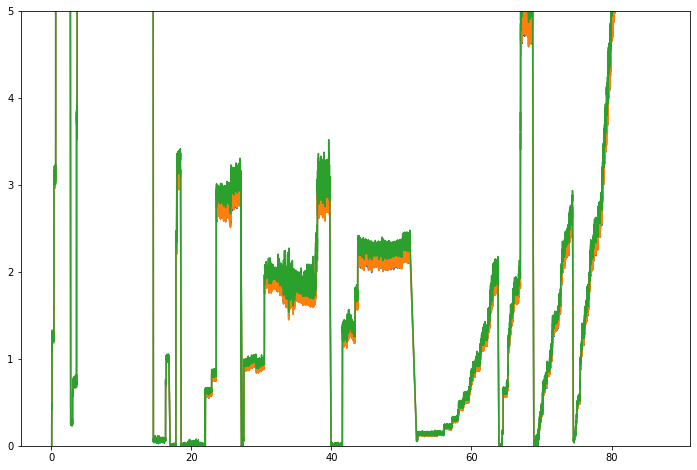

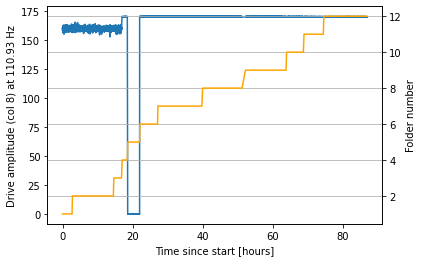

In [344]:
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600
plt.figure(figsize=(12,8))
#plt.subplot(2,1,1)
plt.plot(time_hours, corr_vec[:,0]*1.02)
plt.plot(time_hours, corr_vec[:,1])
plt.plot(time_hours, corr_vec[:,2]*1.06)
#plt.xlim(0.3, 0.7)
plt.ylim(0, 5)
#plt.subplot(2,1,2)

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 110.93 Hz")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)


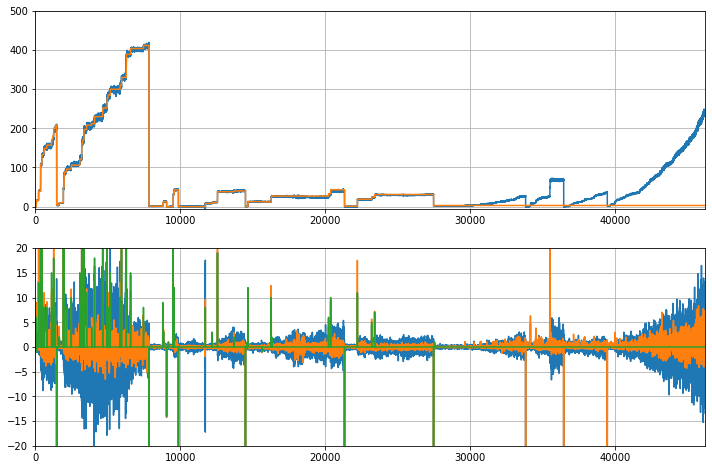

In [345]:
cal_fac = 0.072
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])
recal[1500:7839] = 0.95


xmin, xmax = 0, len(corr_vec)
ymin, ymax = -5, 500
init_charge = -1

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
bpts = (np.abs(dv) < 2) | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
plt.plot(dv2)
## fix up missed steps
step_vals = np.loadtxt(data_dir+"/step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-20,20)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')

In [346]:
## make a dead time vector
live_vec = 1.0*time_hours
bad_pts = (time_hours > 56) | ((time_hours>18.575) & (time_hours<22.007))# (folder_vec == 5) | (time_hours > 55)
live_vec = live_vec[~bad_pts]

time_separation = np.diff(live_vec)
dead_periods = np.where(time_separation > 0.01)[0] ## count any deadtime > 30 seconds
dead_period_edges = []
for j,dp in enumerate(dead_periods):
    dead_period_edges.append([live_vec[dp], live_vec[dp+1]])
dead_period_edges.append([live_vec[-1], time_hours[-1]])

print(dead_period_edges)
#plt.figure()


[[2.706179836988449, 2.7924428402052985], [14.50714031100273, 14.59822541978624], [16.821500230497783, 16.98909640656577], [18.484325021240448, 22.007485670116214], [22.007485670116214, 22.0387393881215], [27.12096900370386, 27.18959450112449], [39.77261636323399, 39.94362969663408], [51.22355193177859, 52.16332438747088], [55.99836826337708, 86.8627707209852]]


In [347]:
def fill_dps():
    yy = plt.ylim()
    for i,dp in enumerate(dead_period_edges):
        if(i==0):
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color='blue', alpha=0.2, label="Dead time")
        else:
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color='blue', alpha=0.2)  
    plt.ylim(yy)

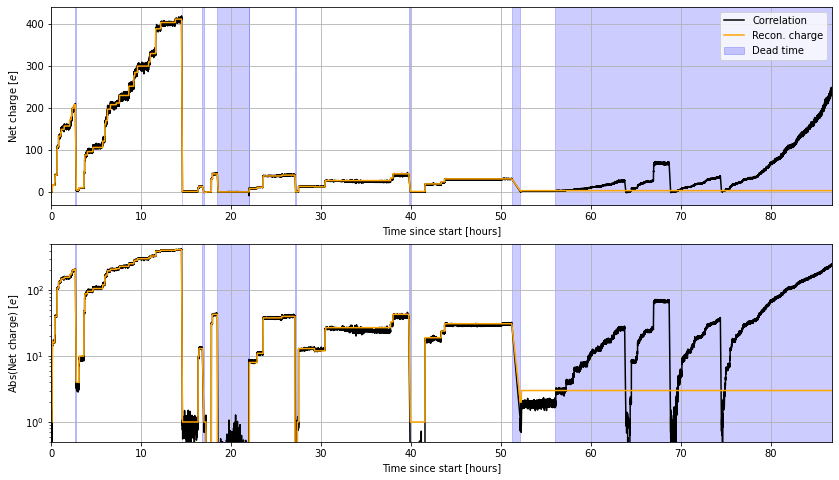

In [348]:
## now make some cleaned up versions of the plots versus time
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.semilogy(time_hours[1:], np.abs(corr_vec[1:,corr_idx]/cal_fac*recal), 'k-', label="Correlation")
plt.plot(time_hours[1:], np.abs(running_charge), '-', color='orange', label="Recon. charge")
plt.grid(True)
plt.ylim(0.5,500)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.ylabel("Abs(Net charge) [$e$]")
plt.xlabel("Time since start [hours]")

plt.savefig("recon_charge_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

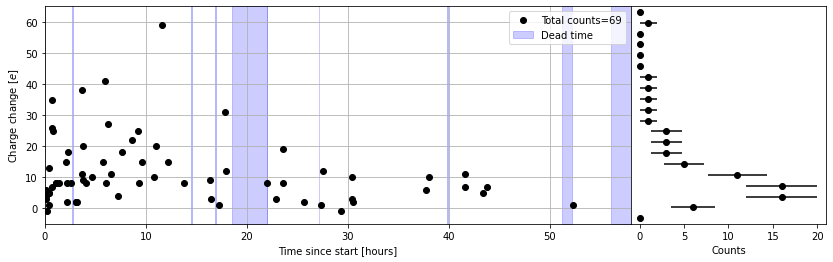

In [349]:
changes = (np.abs(dv_chopped) > 0) & (dv_chopped > -5)
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > -5)
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(14, 4), width_ratios=[3,1])
#plt.plot(time_hours[1:], dv_chopped, 'k')
plt.sca(scatter_ax)
scatter_ax.plot(time_hours[1:][changes], dv_chopped[changes], 'ko', label='Total counts=%d'%np.sum(changes))
plt.ylim(-5,65)
fill_dps()
plt.grid(True)
plt.xlim(0, 58)
plt.ylabel("Charge change [$e$]")
plt.xlabel("Time since start [hours]")
plt.legend()

hh, be = np.histogram(dv_chopped[changes], bins=20, range=(-5,65))
bc = be[:-1] + np.diff(be)/2
#plt.step(be[:-1], hh, where='post', color='k')
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko')
plt.yticks([])
plt.ylim(-5,65)
plt.xlabel("Counts")
plt.subplots_adjust(wspace=0)

plt.savefig("charge_changes_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

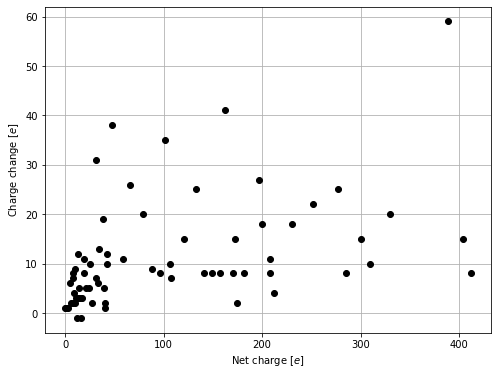

In [350]:
plt.figure(figsize=(8,6))
plt.plot(running_charge[changes], dv_chopped[changes], 'ko')
plt.xlabel("Net charge [$e$]")
plt.ylabel("Charge change [$e$]")
plt.grid(True)
plt.savefig("charge_changes_vs_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [351]:
def lfun(t, N0, t12, tot_time=56, use_norm=True):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12))
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=56):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

4.454091826830295 4.398438829247506


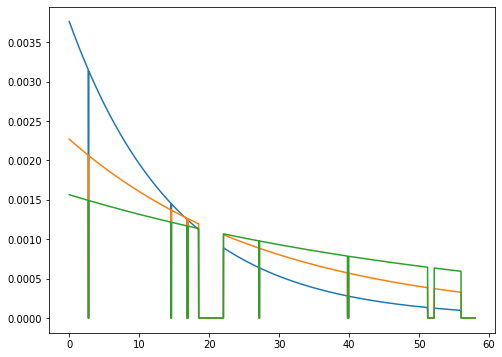

In [352]:
t = np.linspace(0, 58, 5000)
plt.figure(figsize=(8,6))
plt.plot(t, lfun(t, 1, 10.6))
plt.plot(t, lfun(t, 1, 20))
plt.plot(t, lfun(t, 1, 40))
print(np.trapz(lfun(t, 1, 10.6)),np.trapz(lfun(t, 1, 20)))

In [353]:
## time of decays/half life
decay_times = time_hours[1:][changes]
big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
nll_mat_big -= np.min(nll_mat_big)

/var/folders/sz/h29lm_2j53v8vmw0zm_6hxqm0000gn/T/ipykernel_2843/2829892270.py:18: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


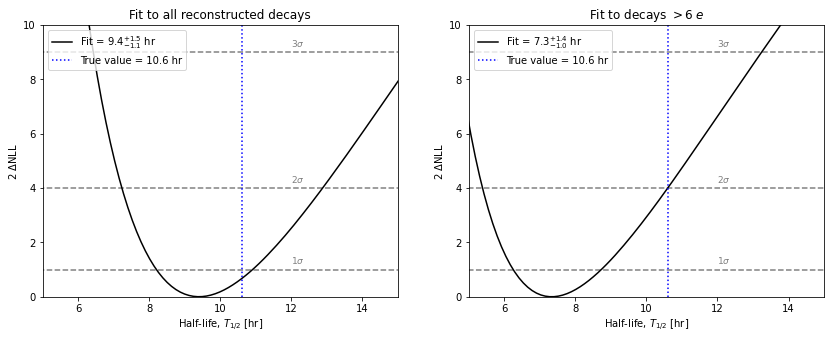

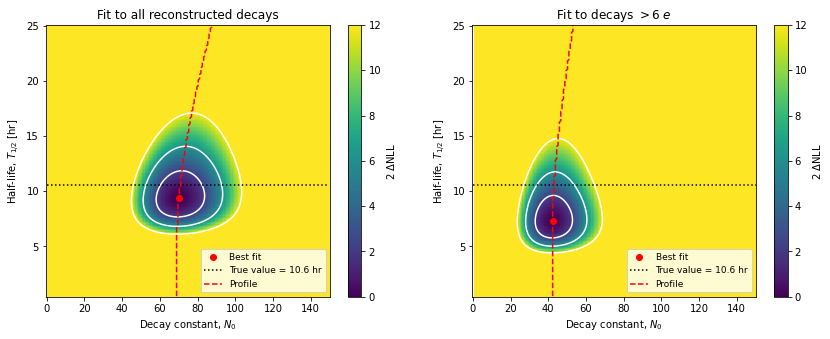

In [354]:
t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all, nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

fig1d = plt.figure(figsize=(14,5))
fig2d = plt.figure(figsize=(14,5))
params_from_profile = []
for j in range(2):

    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    plt.figure(fig1d.number)
    plt.subplot(1,2,j+1)
    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))
    plt.ylim(0, 10)
    levels = [1, 4, 9]
    for lidx, l in enumerate(levels):
        plt.plot(t12_vec, l*np.ones_like(t12_vec), 'k--', alpha=0.5)
        plt.text(12, l+0.2, "$%d\sigma$"%(lidx+1), fontsize=9, color='gray')
    plt.plot([t12_true, t12_true], [0, 10], 'b:', label="True value = %.1f hr"%t12_true)
    plt.xlim(5,15)
    plt.xlabel("Half-life, $T_{1/2}$ [hr]")
    plt.ylabel("2 $\Delta$NLL")
    plt.legend(loc="upper left")
    plt.title(labs[j])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+1)
    plt.pcolormesh(N0_vec, t12_vec, 2*nlls[j].T, cmap='viridis', vmin=0, vmax=12)
    plt.colorbar(label="2 $\Delta$NLL")
    min_loc = np.argmin(nlls[j].T)
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    plt.plot( np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc], 
             'ro', label="Best fit")

    plt.contour( N0_vec, t12_vec, 2*nlls[j].T, levels=[2.3, 6.17, 11.8], colors='w')
    plt.xlabel("Decay constant, $N_0$")
    plt.ylabel("Half-life, $T_{1/2}$ [hr]")
    plt.plot(N0_vec, t12_true*np.ones_like(N0_vec), 'k:', label="True value = %.1f hr"%t12_true)
    plt.title(labs[j])

    ## plot the profile
    plt.plot(profile, t12_vec, 'r--', label= "Profile")
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

    plt.legend(loc='lower right', fontsize=9)

plt.figure(fig1d.number)
plt.savefig("profile_1d_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.figure(fig2d.number)
plt.savefig("profile_2d_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

[70.33492822966507, 9.364321608040202, array([69.61722488]), array([8.25628141]), array([71.05263158]), array([10.84170854])]
[42.3444976076555, 7.2713567839195985, array([42.34449761]), array([6.28643216]), array([42.34449761]), array([8.62562814])]


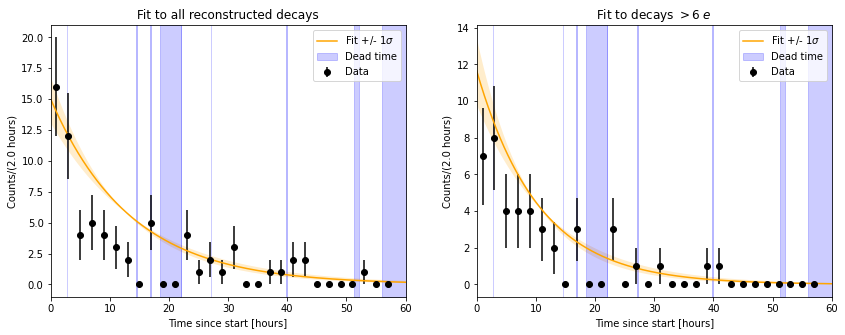

In [355]:
nbins = 29

decay_times_list = [decay_times, big_decay_times]

plt.figure(figsize=(14,5))
for j in range(2):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,58))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(1,2,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,60,1000)
    yy = bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
    print(curr_bp)
    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,60)
    plt.title(labs[j])
    plt.legend()

plt.savefig("decays_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

[70.33492822966507, 9.364321608040202, array([69.61722488]), array([8.25628141]), array([71.05263158]), array([10.84170854])]


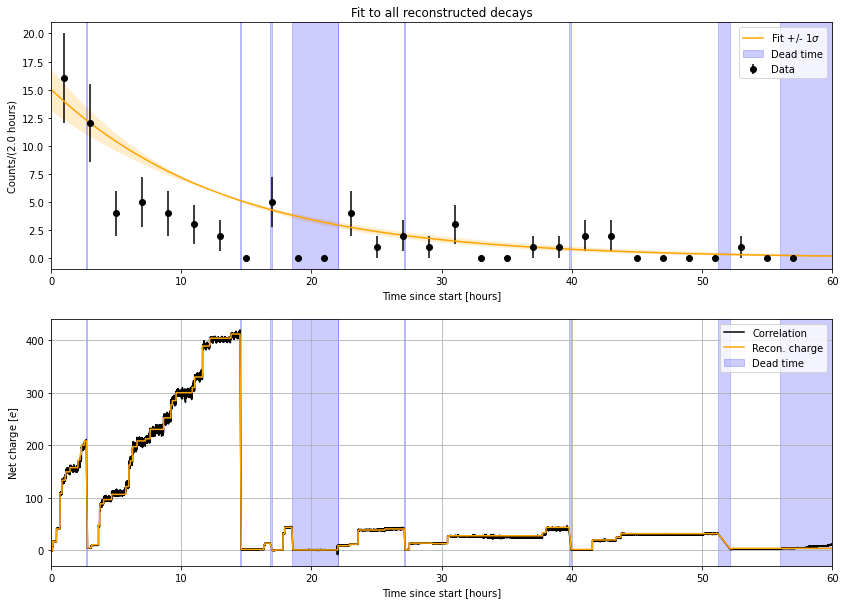

In [356]:
nbins = 29

decay_times_list = [decay_times, big_decay_times]

plt.figure(figsize=(14,10))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,58))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(2,1,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,60,1000)
    yy = bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
    print(curr_bp)
    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,60)
    plt.title(labs[j])
    plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="upper right")
plt.xlim(0,60)

plt.savefig("decays_vs_time_with_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [357]:
print(changes)

[False False False ... False False False]


In [358]:
def exp_fun(x, A, t12=10.6):
    lam = np.log(2)/t12
    return A*np.exp(-lam*x)

In [359]:
time_between = np.diff(decay_times)
dt = (time_hours[1]-time_hours[0])
gpts = time_between>1.1*dt
time_between = time_between[gpts]

[16.44119128 17.9373863  27.51355905 30.53415811]


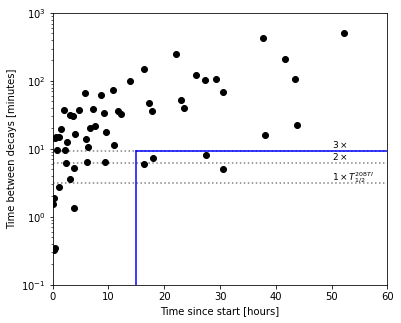

In [360]:
plt.figure(figsize=(6,5))
plt.semilogy(decay_times[1:][gpts], time_between*60, 'ko')
plt.xlim(0,60)
plt.ylim(0.1,1e3)
t12_tl208 = 3.1
for i in range(1,4):
    plt.plot([0,60], [i*t12_tl208, i*t12_tl208], 'k:', alpha=0.5)
    if(i==1):
        plt.text(50, i*t12_tl208*1.1, r"$%d \times T_{1/2}^{208Tl}$"%(i), fontsize=9, color='k')
    else:
        plt.text(50, i*t12_tl208*1.1, r"$%d \times$"%(i), fontsize=9, color='k')

xcut, ycut = 15, 9.3

all_times = decay_times[1:][gpts]
cut_pos = (all_times > xcut) & (time_between*60 < ycut)
cand_decay_times = all_times[cut_pos]
bi_decay_times = all_times[np.roll(cut_pos,-1)]
print(cand_decay_times)

plt.plot( [xcut,xcut], [0.1, ycut], 'b')
plt.plot( [xcut,60], [ycut, ycut], 'b')
plt.xlabel("Time since start [hours]")
plt.ylabel("Time between decays [minutes]")

plt.savefig("time_between_tl208_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

T12 = 18.2 +/- 2.4


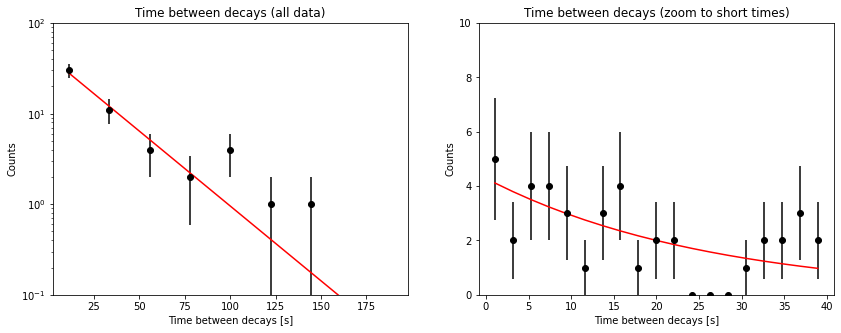

In [361]:
tbins = np.linspace(0,200,10)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

err = np.sqrt(hh)
err[err==0] = 1
bp, bcov = opt.curve_fit(exp_fun, bc, hh, p0=[100, 10.6*60], sigma=err)
print("T12 = %.1f +/- %.1f"%(bp[1], np.sqrt(bcov[1,1])))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp), 'r')
plt.gca().set_yscale("log")
plt.ylim(0.1,100)
plt.xlabel("Time between decays [s]")
plt.ylabel("Counts")
plt.title("Time between decays (all data)")

plt.subplot(1,2,2)
tbins = np.linspace(0,40,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp)/10, 'r')
#plt.gca().set_yscale("log")
plt.ylim(0,10)
plt.xlabel("Time between decays [s]")
plt.ylabel("Counts")
plt.title("Time between decays (zoom to short times)")

plt.savefig("time_between_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


8792
9506
14598
16265


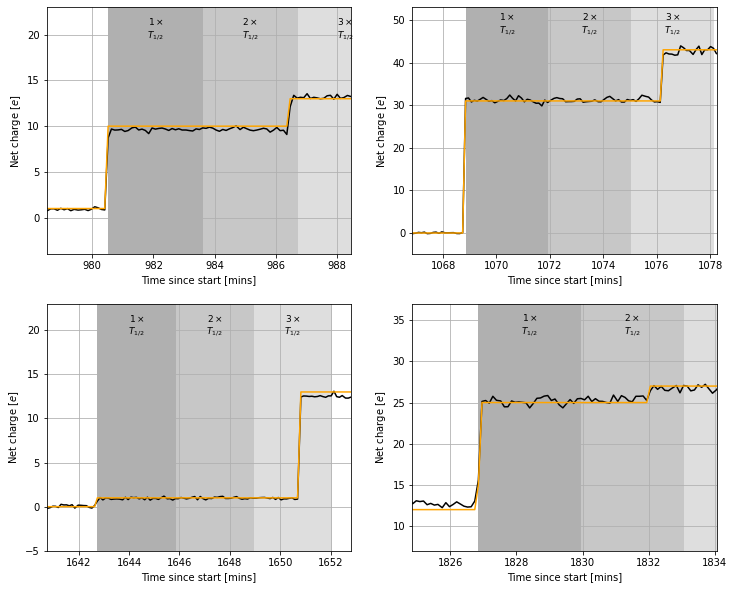

In [365]:
## now find the Tl-208 candidate decays and plot a zoom

low_wind, high_wind = 2, 2
hrs_to_mins = 60

plt.figure(figsize=(12,10))
figidx = 1
for bi_hrs,cdt_hrs in zip(bi_decay_times,cand_decay_times):

    cdt = cdt_hrs*hrs_to_mins
    cdt_bi = bi_hrs*hrs_to_mins

    idx_of_bi = np.argmin(np.abs(time_hours[1:]*hrs_to_mins - cdt_bi))
    bi_time = time_hours[1:][idx_of_bi]*hrs_to_mins
    print(idx_of_bi)

    plt.subplot(2,2,figidx)
    plt.plot(time_hours[1:]*hrs_to_mins, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
    plt.plot(time_hours[1:]*hrs_to_mins, running_charge, '-', color='orange', label="Recon. charge")
    plt.grid(True)
    fill_dps()
    plt.xlim(cdt_bi-low_wind, cdt+high_wind)
    gpts = (time_hours[1:]*hrs_to_mins > cdt_bi-low_wind) & (time_hours[1:]*hrs_to_mins < cdt+high_wind)
    y1, y2 = np.min(running_charge[gpts])-5, np.max(running_charge[gpts])+10
    plt.ylim(y1,y2)
    for i in range(1,4):
        plt.fill_between([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208], [y1, y1], [y2, y2], color='k', alpha=0.4-(i*0.09),edgecolor=None)
        xp = np.mean([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208])
        if(xp > cdt+high_wind): break
        plt.text(xp, y2-1, r"$%d \times$"%i +"\n$T_{1/2}$", fontsize=9, color='k', verticalalignment='top', horizontalalignment='center')
    plt.xlabel("Time since start [mins]")
    plt.ylabel("Net charge [$e$]")
    figidx+=1
    #plt.legend(loc="upper left")
    plt.savefig("candidate_bi_tl_%s.png"%file_label, dpi=300, bbox_inches="tight")

16.0
16.0


(100.0, 120.0)

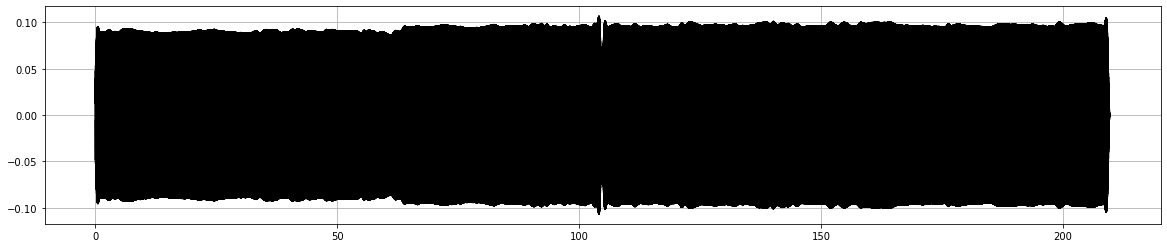

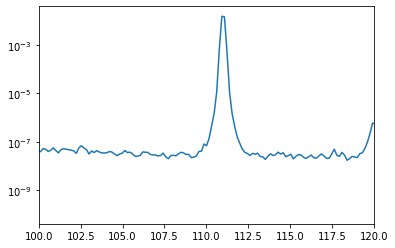

In [363]:
## code to plot individual files charge change
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=1210
nfiles = 2
plt.figure(figsize=(20,4))
for nf in range(nfiles):
    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    #fn = np.array([104, 118])/5000
    fn = np.array([110, 112])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.plot(tvec,fdat, 'k')
    plt.grid(True)
    #plt.xlim(60,65)
    #plt.ylim(0.06, 0.10)

plt.figure()
f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
plt.semilogy(f,p)
plt.xlim(100,120)

Now let's analyze whether there are any kicks correlated with the charge changes: